# **Logistic Regression** 

Lab designed by **Professor Christopher Yau** University of Manchester.

## Overview

This practical is designed to illustrate the construction of a Logistic Regression model for a binary classification task. In this exercise you will:

1. Use Python and libraries including numpy (numerical computations) and matplotlib (visualisaton).
2. Learn to simulate an artificial dataset to use as test data for the classifer.
3. Create functions in Python to perform the individuals steps of a Logistic Regression model.
4. Write a complete Logistic Regression based classifier using all the functions in [3].
5. Visualise and plot the outputs.

## Pre-requisities

This lab exercise assumes some basic programming familiarity with Python. The exercise is designed to avoid excessive use of custom libraries and tries to use as much of standard Python as possible. The exemplar code therefore is designed for readability and interpretability (rather than efficiency) to help you to learn about how Logistic Regression works. 

## Getting Started
First, we will import some libraries that will be useful later.

In [1]:
import matplotlib.pyplot as plt # for visualisation
import random # for random number generation
import numpy as np # for numerical libraries

random.seed(242785) # seed the random number generators
np.random.seed(64254)

## Simulating data

In this part of the code, we will simulate some data using the generative model that underlies the logistic regression model.

First, we will specify some parameters $\bf{w}$ for our model:

In [2]:
w0 = 0 # parameter values used to generate data
w1 = -1.5
w2 = 2.5

Normally, in an experiment or classification tasks, the input or predictors would be given. But here, we need to generate some input/predictor values $(x_1, x_2)$. We will do this by sampling random vectors from a [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution).

In [3]:
n = 50 # number of training samples to generate

In [4]:
mean = [0, 0] # mean
cov = [[3, 0.5], [0.5, 3]] # covariance matrix
x1, x2 = np.random.multivariate_normal(mean, cov, n).T # sample from a multivariate normal distribution

Now recall we next generate latent variables $z$ of the form using our inputs and parameters and convert into outputs $y$ by taking the sign:
$$
  z = w_1 x_1 + w_2 x_2 + w_0,
$$
$$
  h = \frac{1}{1+\exp(-z)},
$$
$$
  p(y=1) = h, 
  p(y=0) = 1-h.
$$

In [5]:
z = w1*x1 + w2*x2 + w0
h = 1/(1+np.exp(-z))
y = np.zeros(n)
for i in range(n):
  y[i] = np.random.choice(np.array([0, 1]), 1, replace=True, p=[1-h[i], h[i]]) 

Lets plot the data to see how the two classes separate (or not) in $(x_1, x_2):

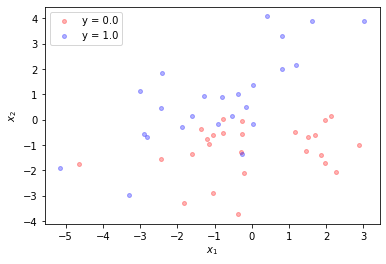

In [6]:
cdict = {1: 'red', 2: 'blue', 3: 'green'} # colour scheme
fig, ax = plt.subplots()
j = 1
for g in np.unique(y):
    ix = np.where(y == g)
    ax.scatter(x1[ix], x2[ix], c = cdict[j], label = "y = " + str(g), s = 16, alpha=0.3)
    j = j + 1
ax.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

The classes do separate so now lets apply our logistic regression algorithm does this.

## Logistic Regression

We will now construct the logistic regression classifier to classify this data. First we will define some useful functions. 

The first is a prediction function that takes inputs $(x_1, x_2)$ and parameters $(w_0, w_1, w_2)$ and outputs a prediction $\hat{y}$:
$$
	h = p(y = 1|{\bf x},{\bf w}) = \frac{1}{1 + \exp(-\underbrace{[{\bf w}^t {\bf x} + w_0]}_z) }
$$

In [7]:
# define the logistic function
def logistic_fn(z):
  h = 1/(1+np.exp(-z))
  return h
  
# define prediction function
def predict_fn(x1, x2, w0, w1, w2):
  z = w1*x1 + w2*x2 + w0
  h = logistic_fn(z)
  return h

In [8]:
# define classification function
def classify_fn(d, x1, x2, w0, w1, w2):
  z = w1*x1 + w2*x2 + w0
  h = logistic_fn(z)
  ix = np.where(h < d)
  y = np.zeros(x1.size)
  y[ix] = 1.0
  return y

The loss function is given by:
\begin{align*}
	l({\bf w}) = - \frac{1}{n} \log L({\bf w}|D) = - \frac{1}{n} \sum_{i=1}^n \left [ y_i \log h({\bf w}, {\bf x}_i) + (1-y_i) \log ( 1 - h({\bf w}, {\bf x}_i) \right ]
\end{align*}

In [9]:
# definition of loss function
def loss_fn(x1, x2, y, w0, w1, w2):
  h = predict_fn(x1, x2, w0, w1, w2)
  loss = -np.sum( y*np.log(h) + (1-y)*np.log(1-h) )
  return loss 

The general form of a SGD update is to take the current value of the parameter and then to subtract off the gradient scaled by a learning rate in this case denoted by $\lambda$:
  $$
		w_j \leftarrow w_j  + \lambda [ y_i - h({\bf w}, {\bf x}_i) ] x_i^j 
	$$

In [10]:
# definition of update function
def update_fn(y_i, h_i, x1_i, x2_i, w0, w1, w2, n, batch_size, learning_rate):
  w1 = w1 + (n/batch_size)*learning_rate*np.sum((y_i - h_i)*x1_i)
  w2 = w2 + (n/batch_size)*learning_rate*np.sum((y_i - h_i)*x2_i)
  w0 = w0 + (n/batch_size)*learning_rate*np.sum((y_i - h_i))  
  return w0, w1, w2

We will now specify how many training epochs to use (an epoch is essentially one update step), learning rate and mini-batch sizes:

In [11]:
n_epochs = 5000 # number of training epochs
learning_rate = 0.001 # learning rate
batch_size = 1 # mini-batch siz

Initialise the parameter estimates:

In [12]:
w1_hat = 0 # initialise parameter estimate
w2_hat = 0
w0_hat = 0

Now we begin the logistic regression classification but first we set up some arrays to hold the parameter and loss values as they change with each update:

In [13]:
loss_vec = np.zeros(n_epochs)
w0_vec = np.zeros(n_epochs)
w1_vec = np.zeros(n_epochs)
w2_vec = np.zeros(n_epochs)

Now lets iterate the perceptron update steps up to the maximum number of epochs:

In [14]:
for epoch in range(n_epochs): # for each epoch
  
  # sample a mini-batch of training data points
  ix = np.random.choice(n, batch_size, replace=False) 
  y_i = y[ix]
  x1_i = x1[ix]
  x2_i = x2[ix]
  
  # predict
  h_i = predict_fn(x1_i, x2_i, w0_hat, w1_hat, w2_hat)

  # update 
  w0_hat, w1_hat, w2_hat = update_fn(y_i, h_i, x1_i, x2_i, w0_hat, w1_hat, w2_hat, n, batch_size, learning_rate)

  # compute loss
  loss = loss_fn(x1, x2, y, w0_hat, w1_hat, w2_hat)

  # store
  loss_vec[epoch] = loss
  w0_vec[epoch] = w0_hat
  w1_vec[epoch] = w1_hat
  w2_vec[epoch] = w2_hat

After the perceptron has finished running, we can plot the loss function to check for convergence:

Text(0, 0.5, 'Loss')

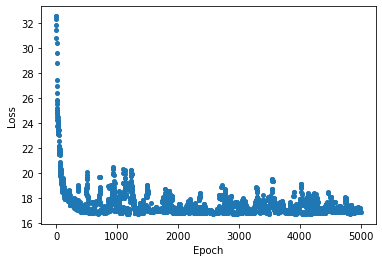

In [15]:
plt.scatter(np.arange(0, n_epochs), loss_vec, s=16)
plt.xlabel("Epoch")
plt.ylabel("Loss")

Lets see the classification using the true and estimated parameters:

In [16]:
d = 0.5 # decision threshold
y_hat = classify_fn(d, x1, x2, w0_hat, w1_hat, w2_hat)

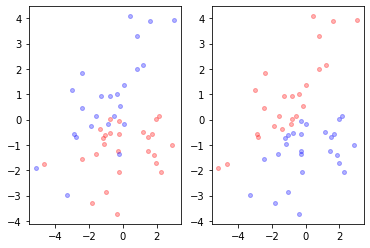

In [17]:
# set up the plots
fig, (ax1, ax2) = plt.subplots(1, 2)
j = 1
for g in np.unique(y):
    ix = np.where(y == g)
    ax1.scatter(x1[ix], x2[ix], c = cdict[j], label = "y = " + str(g), s = 16, alpha=0.3)
    j = j + 1

j = 1
for g in np.unique(y_hat):    
    ix = np.where(y_hat == g)
    ax2.scatter(x1[ix], x2[ix], c = cdict[j], label = "$\hat{y} = $" + str(g), s = 16, alpha=0.3)
    j = j + 1


Let compute the decision boundaries, recall from the lecture that at the decision boundary:
$$
  z = \log \left ( \frac{d}{1-d} \right ) = w_1 x_1 + w_2 x_2 + w_0
$$
or 
$$
  x_2 = \frac{1}{w_2} \left ( \log \left ( \frac{d}{1-d} \right ) - w_1 x_1 - w_0 \right )
$$
lets compute this both for the true parameters and the estimated ones from the perceptron to compare.

In [18]:
# compute decision boundary direction
x1_start = -2.5
x1_end = 2.5
x2_start = (np.log(d/(1-d)) - w0 - w1*x1_start)/w2
x2_end = (np.log(d/(1-d)) - w0 - w1*x1_end)/w2
x2_start_est = (np.log(d/(1-d)) - w0_hat - w1_hat*x1_start)/w2_hat
x2_end_est = ( np.log(d/(1-d)) - w0_hat - w1_hat*x1_end)/w2_hat

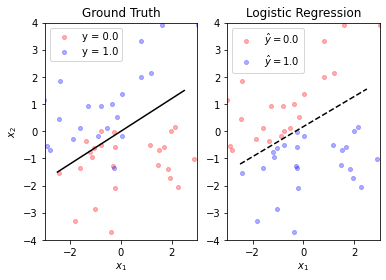

In [21]:
# set up the plots
fig, (ax1, ax2) = plt.subplots(1, 2)
j = 1
for g in np.unique(y):
    ix = np.where(y == g)
    ax1.scatter(x1[ix], x2[ix], c = cdict[j], label = "y = " + str(g), s = 16, alpha=0.3)
    j = j + 1

j = 1
for g in np.unique(y_hat):    
    ix = np.where(y_hat == g)
    ax2.scatter(x1[ix], x2[ix], c = cdict[j], label = "$\hat{y} = $" + str(g), s = 16, alpha=0.3)
    j = j + 1

# plot the decision boundaries
ax1.plot([x1_start, x1_end], [x2_start, x2_end], 'k-')
ax2.plot([x1_start, x1_end], [x2_start_est, x2_end_est], 'k--')
ax1.legend()
ax2.legend()
ax1.set_xlim(-3, 3) 
ax2.set_xlim(-3, 3) 
ax1.set_ylim(-4, 4) 
ax2.set_ylim(-4, 4) 
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax2.set_xlabel("$x_1$")
ax1.set_title('Ground Truth')
ax2.set_title('Logistic Regression')
plt.show()

The two plots look near-identical so lets highlight the classification errors to make it easier:

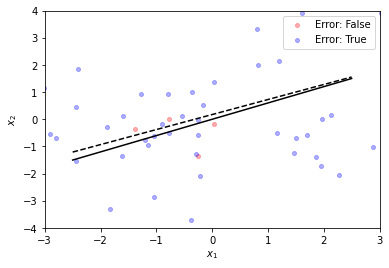

In [22]:
classification_error = (y!=y_hat) # compute which training samples are misclassified
fig2, ax = plt.subplots()
j = 1
for g in np.unique(classification_error):
    ix = np.where(classification_error == g)
    ax.scatter(x1[ix], x2[ix], c = cdict[j], label = "Error: " + str(g), s = 16, alpha=0.3)
    j = j + 1
ax.legend()
ax.plot([x1_start, x1_end], [x2_start, x2_end], 'k-')
ax.plot([x1_start, x1_end], [x2_start_est, x2_end_est], 'k--')
ax.set_xlim(-3, 3) 
ax.set_ylim(-4, 4) 
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

## Exercises

Modify the data simulation procedure to:

1. Increase/decrease the separation between the two classes, what happens to the performance of the classifier?
2. Vary the number of training samples, how does this alter the behaviour of the algorithm?
3. Can you plot a graph of degree of separation/number of training samples versus classifier performance?

How happens if you use a data generating procedure which is not the one assumed by the logistic regression algorithm?

## Extended Exercises [Optional]

The following exercises are not compulsory but would test your understanding and should be done in your own time (they will not be covered in the labs): 

1.   Re-design the code to allow for any number of inputs (you will need to use matrix/vector operations provided by the numpy library).
2.   Apply your code to data from the UCI Data Repository (https://archive.ics.uci.edu/ml/datasets.php).